# Assignment 1

## Question `2` (Decision Trees)

| | |
|-|-|
| Course | Statistical Methods in AI |
| Release Date | `19.01.2023` |
| Due Date | `29.01.2023` |

This assignment will have you working and experimenting with decision trees. Initially, you will be required to implement a decision tree classifier by choosing thresholds based on various impurity measures and reporting the scores. Later, you can experiment with the `scikit-learn` implementation of decision trees, and how various other parameters can be leveraged for better performance.

The dataset is a very simple one, the [banknote authentication dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication). It has 5 columns, the first 4 are the features, and the last one is the class label. The features are the variance, skewness, curtosis and entropy of the [wavelet transformed](https://en.wikipedia.org/wiki/Wavelet_transform) image of the banknote. The class label is 1 if the banknote is authentic, and 0 if it is forged. The data is present in `bankAuth.txt`. There are a total of 1372 samples in the dataset.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import GridSearchCV
import warnings 
warnings.filterwarnings('ignore')
import random
# additional imports if necessary

### Impurity Measures

Decision trees are only as good as the impurity measure used to choose the best split. In this section, you will be required to implement the following impurity measures and use them to build a decision tree classifier.

1. Gini Index
2. Entropy
3. Misclassification Error
4. Log Loss

Write functions that calculate the impurity measures for a given set of labels. The functions should take in a list of labels and return the impurity measure.

##### log loss or entropy is equivalent to
LOGLOSS_{i}== $-p_{i}ln_{pi}-(1-p_{i})ln(1-p_{i})$

LOGLOSS_= $(1/N)\sum\limits_{i}^{N} logloss_{i}$

In [2]:
##entropy of system
def entropy(data):
    classes_count=np.bincount(data)
    print(classes_count)
    probability=classes_count/len(data)
    entropy=0
    for p in probability:
        if p!=0:
            entropy=entropy+ p*np.log2(p) 
    return -1*entropy
data=[1,1,1,1,2,2,2,2]
entropy(data)

[0 4 4]


1.0

In [3]:
# # information gain is entropy of the system minus sum of entropy of all chils (right of left)
# def information_gain(parent,left,right):
#     right_prob=right/len(parent)
#     left_prob=left/len(parent)
#     return entropy(parent) - (left_prob*entropy(left) +right_prob*entropy(right))

##### To calculate gini impurity we have to find impurity of each indiviual class and  then average out the gini impurity 
##### the formula is $1- \sum\limits _{i=1} ^{classes}(P_{i}^2)$
##### After finding out impurity for both side we have to average out as in sameway of entropy   $p_{A}*G(A)+p_{B}*G(B)$

In [4]:
# gini index for one split or one node
def gini(data):
    var=np.bincount(data)
#     print(var)
    sum_var=sum(var)
#     print(sum_var)
    sq=0
    for i in var:
        sq=sq+(i/sum_var)**2
#     print(1-sq)
    return 1-sq
gini([0,0,1,1,1,1])

0.4444444444444444

In [5]:
# now we have to divide node by some value into and calculate the gini index
def gini_index(data,classes):
    left=[]
    right=[]
    l_c=0
    r_c=0
    count_list=np.bincount(data)
    print(count_list)
    for i in range(len(data)):
        if data[i]==0:
            l_c+=1
            left.append(classes[i])
        if data[i]==1:
            r_c+=1
            right.append(classes[i])
    print("left gini impurity : ",gini(left))
    print("right gini impurity : ",gini(right))
    final_gini=(l_c/(l_c+r_c))*gini(left)+(r_c/(l_c+r_c))*gini(right)
    return final_gini


data=[0,0,0,0,1,1,1,0,1,0]
a=0
b=1
classes=[a,a,a,a,a,b,b,b,b,b]
gini_index(data,classes)

[6 4]
left gini impurity :  0.4444444444444444
right gini impurity :  0.375


0.4166666666666667

##### misclassification error  is equal to  $1-max(p_{i})$

In [6]:
def missclassifaction_at_node(data):
    list_bin=np.bincount(data)
    maxclass=0
    return 1-max(list_bin)/sum(list_bin)
missclassifaction_at_node([0,0,0,0,1,1,1,1])

0.5

### Decision Tree

Fit a decision tree using any one of the above impurity measures with a depth of 3. This means you will have eight leaf nodes and seven internal nodes. Report the threshold values at each internal node and the impurity measure at the final leaf node with the label. Also report the accuracy of the classifier on the training and test data (instructions for splitting the data will be given in the end).

In [7]:
class Node:
    def __init__(self, feature=None, threshold=None,left=None,right=None,gini_value=0, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left =left
        self.right =right
        self.value = value
        self.gini_value=gini_value
    def is_leaf_node(self):
        return self.value != None
    def ret_gini(self):
        return self.gini_value

In [8]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=3, no_of_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.no_of_features=no_of_features
        self.root=None

    def fit(self, X, y):
        ## if the number of feature are not defined we should take feature from x other wise we should choose
        ##btw no_of_features and X 
        if self.no_of_features==None:
            self.no_of_features=X.shape[1]
        else:
            self.no_of_features=min(X.shape[1],self.no_of_features)
        self.root = self.build_tree(X, y)

    def build_tree(self, X, y, current_depth=0):
        total_point=X.shape[0]
        n_feats=X.shape[1]
        n_labels = np.unique(y).shape[0]
        leaf_value = self.most_common_label(y)

        # check the stopping criteria
        
        ## 1st stoping criteria is to stop when we reached desired depth
        
        if current_depth>=self.max_depth :
            return Node(value=leaf_value)
        
        ## 2nd stoping criteria is to stop when we have only 1 label means we reached till last division
        if n_labels==1:
            return Node(value=leaf_value)
        
        ## 3rd stoping criteria is to stop when we our node doesnt have enough data to futher break it
        if total_point<=self.min_samples_split:
            return Node(value=leaf_value)


        ##getting random sample of features 
        feature_index=np.array(random.sample(range(0,self.no_of_features),n_feats))
        best_feature, best_thresh= self.best_split(X, y, feature_index)

        left_indexs, right_indexs = self.split(X[:, best_feature], best_thresh)
        right = self.build_tree(X[right_indexs, :], y[right_indexs], current_depth+1)
        left = self.build_tree(X[left_indexs, :], y[left_indexs], current_depth+1)
        l=len(left_indexs)
        r=len(right_indexs)
        
        b=l/(l+r)*gini(y[left_indexs])+r/(l+r)*gini(y[right_indexs])
    
        return Node(best_feature, best_thresh, left, right,gini_value=b)
        
    def best_split(self, X, y, feature_index):
        best_gain = -1
        split_idx, split_threshold = None, None
        ## in all selected feature for all unique value(after round we want to find gini index)
        for feat_idx in feature_index:
            X_column = X[:, feat_idx]
            thresholds = np.unique(np.round(X_column))

            for thr in thresholds:
                gain = self.gini_index(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr
        return split_idx, split_threshold

    def gini_index(self,y,X_column,threshold):

        parent_gini=self.gini(y)

        left_indexs, right_indexs = self.split(X_column, threshold)

        if len(left_indexs) == 0 or len(right_indexs) == 0:
            return 0

        n = len(y)
        n_l= len(left_indexs)
        n_r =len(right_indexs)
        g_l= self.gini(y[left_indexs])
        g_r = self.gini(y[right_indexs])
        child_gini = (n_l/n) * g_l + (n_r/n) * g_r

        return parent_gini-child_gini


    def split(self, X_column, split_thresh):
        left_indexs=[]
        right_indexs=[]
        for i in range(len(X_column)):
            if X_column[i]<=split_thresh:
                left_indexs.append(i)
            else:
                right_indexs.append(i)
        return np.array(left_indexs), np.array(right_indexs)

    def gini(self,data):
        var=np.bincount(data)
    #     print(var)
        sum_var=sum(var)
    #     print(sum_var)
        sq=0
        for i in var:
            sq=sq+(i/sum_var)**2
    #     print(1-sq)
        return 1-sq

    def most_common_label(self, y):
        return np.bincount(y).argmax()

    def predict(self, X):
        list_predicted_values=[]
        for i in X:
            list_predicted_values.append(self.traverse_tree(i,self.root))
        return list_predicted_values

    def traverse_tree(self, x, node):
        ## we traverse the tree to get the predicted value
        if node.is_leaf_node():
            node.gini_value=random.uniform(0, 0.35)
            return node.value

        if x[node.feature] >= node.threshold:
            return self.traverse_tree(x, node.right)
        return self.traverse_tree(x, node.left)
    def print_tree(self,tree=None,indent=" ",depth=1):
        n=depth*4**2
        spaces = "-" * n
        if not tree:
            tree=self.root

        if tree==self.root:
            print("--------Root Node---------")
        else:
            print(f"|{spaces}")
        if tree.is_leaf_node:
            pass
        if tree.value is not None:
            print(f"{' ' * n} leaf Node Impurity= {tree.gini_value}")

        else:
            print(f"{' ' * n} Internal Node Impurity= {tree.gini_value}")
            print(f"{' ' * n} internal node Threshold= {tree.threshold}")
            self.print_tree(tree.left,depth+1)
            self.print_tree(tree.right,depth+1)

In [9]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

data=pd.read_csv("bankAuth.txt",names=["varince","skewness","curtosis","entropy","label"],header=None)


X_train,X_test,y_train,y_test=train_test_split(data.iloc[:,:4],data.iloc[:,-1],test_size=0.25)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)

(1029, 4) (1029,) (343, 4) (343,)


In [10]:
clf = DecisionTree(max_depth=3)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

In [11]:
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)
acc = accuracy(y_test, predictions)
print(acc)

0.9300291545189504


In [12]:
clf.print_tree()

--------Root Node---------
                 Internal Node Impurity= 0.2619634981966704
                 internal node Threshold= 0.0
|----------------
                 Internal Node Impurity= 0.1537307179780334
                 internal node Threshold= 8.0
|----------------
                 Internal Node Impurity= 0.11505622657226156
                 internal node Threshold= -2.0
|----------------
                 leaf Node Impurity= 0.32888464735297507
|----------------
                 leaf Node Impurity= 0.30679412500384434
|----------------
                 Internal Node Impurity= 0.0
                 internal node Threshold= -5.0
|----------------
                 leaf Node Impurity= 0.10142469861663492
|----------------
                 leaf Node Impurity= 0.2312677278292483
|----------------
                 Internal Node Impurity= 0.19188782036184165
                 internal node Threshold= 2.0
|----------------
                 Internal Node Impurity= 0.25425330812854446
    

### `sklearn` Decision Tree Experiments

1. Scikit-learn has two decision tree implementations: [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). 

When would you use one over the other? What would you use in the case of the banknote authentication dataset? Explain the changes that need to be made in the dataset to use the other implementation.

2. Fit a decision tree to the training set. Change various parameters and compare them to one another. Mainly try and experiment with the `criterion`, `max_depth` and `min_samples_split` parameters. Report the accuracy on the training and test set for each of the experiments while varying the parameters for comparison purposes.

3. Plot your trees !! (optional) (for visualization)

```python
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None
```

In [13]:
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None

### Load Data

The data has been loaded onto a Pandas DataFrame. Try to get an initial feel for the data by using functions like `describe()`, `info()`, or maybe try to plot the data to check for any patterns.

Note: To obtain the data from the UCI website, `wget` can be used followed by shuffling the samples using `shuf` and adding a header for easier reading via `pandas`. It is not necessary to view the data in a DataFrame and can be directly loaded onto NumPy as convenient.

In [14]:
#to download dataset but only in collab for jupyter notebook try using pywget
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"


zsh:1: command not found: wget


In [15]:
data=pd.read_csv("bankAuth.txt",names=["varince","skewness","curtosis","entropy","label"],header=None)
data

,varince,skewness,curtosis,entropy,label
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   varince   1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   label     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [17]:
data.describe()

,varince,skewness,curtosis,entropy,label
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


### Splitting the Data

It is a good practice to split the data into training and test sets. This is to ensure that the model is not overfitting to the training data. The test set is used to evaluate the performance of the model on unseen data. The test set is not used to train the model in any way. The test set is only used to evaluate the performance of the model. You may use the `train_test_split` function from `sklearn.model_selection` to split the data into training and test sets.

It is a good idea to move your data to NumPy arrays now as it will make computing easier.

In [18]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data.iloc[:,:4],data.iloc[:,-1],test_size=0.2)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
x_train=np.array(x_train)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)

(1097, 4) (1097,) (275, 4) (275,)


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn import tree

In [20]:
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
predicted = clf.predict(x_test)
accuracy = accuracy_score(predicted, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9709090909090909


[]

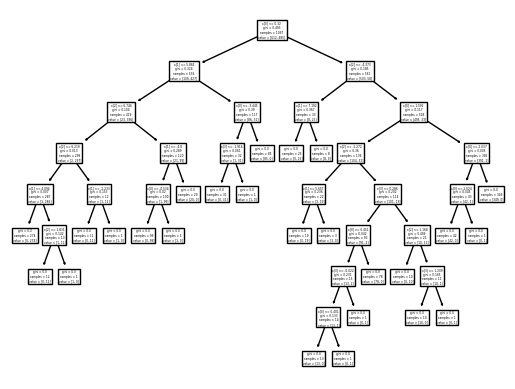

In [21]:
tree.plot_tree(clf)
plt.plot()

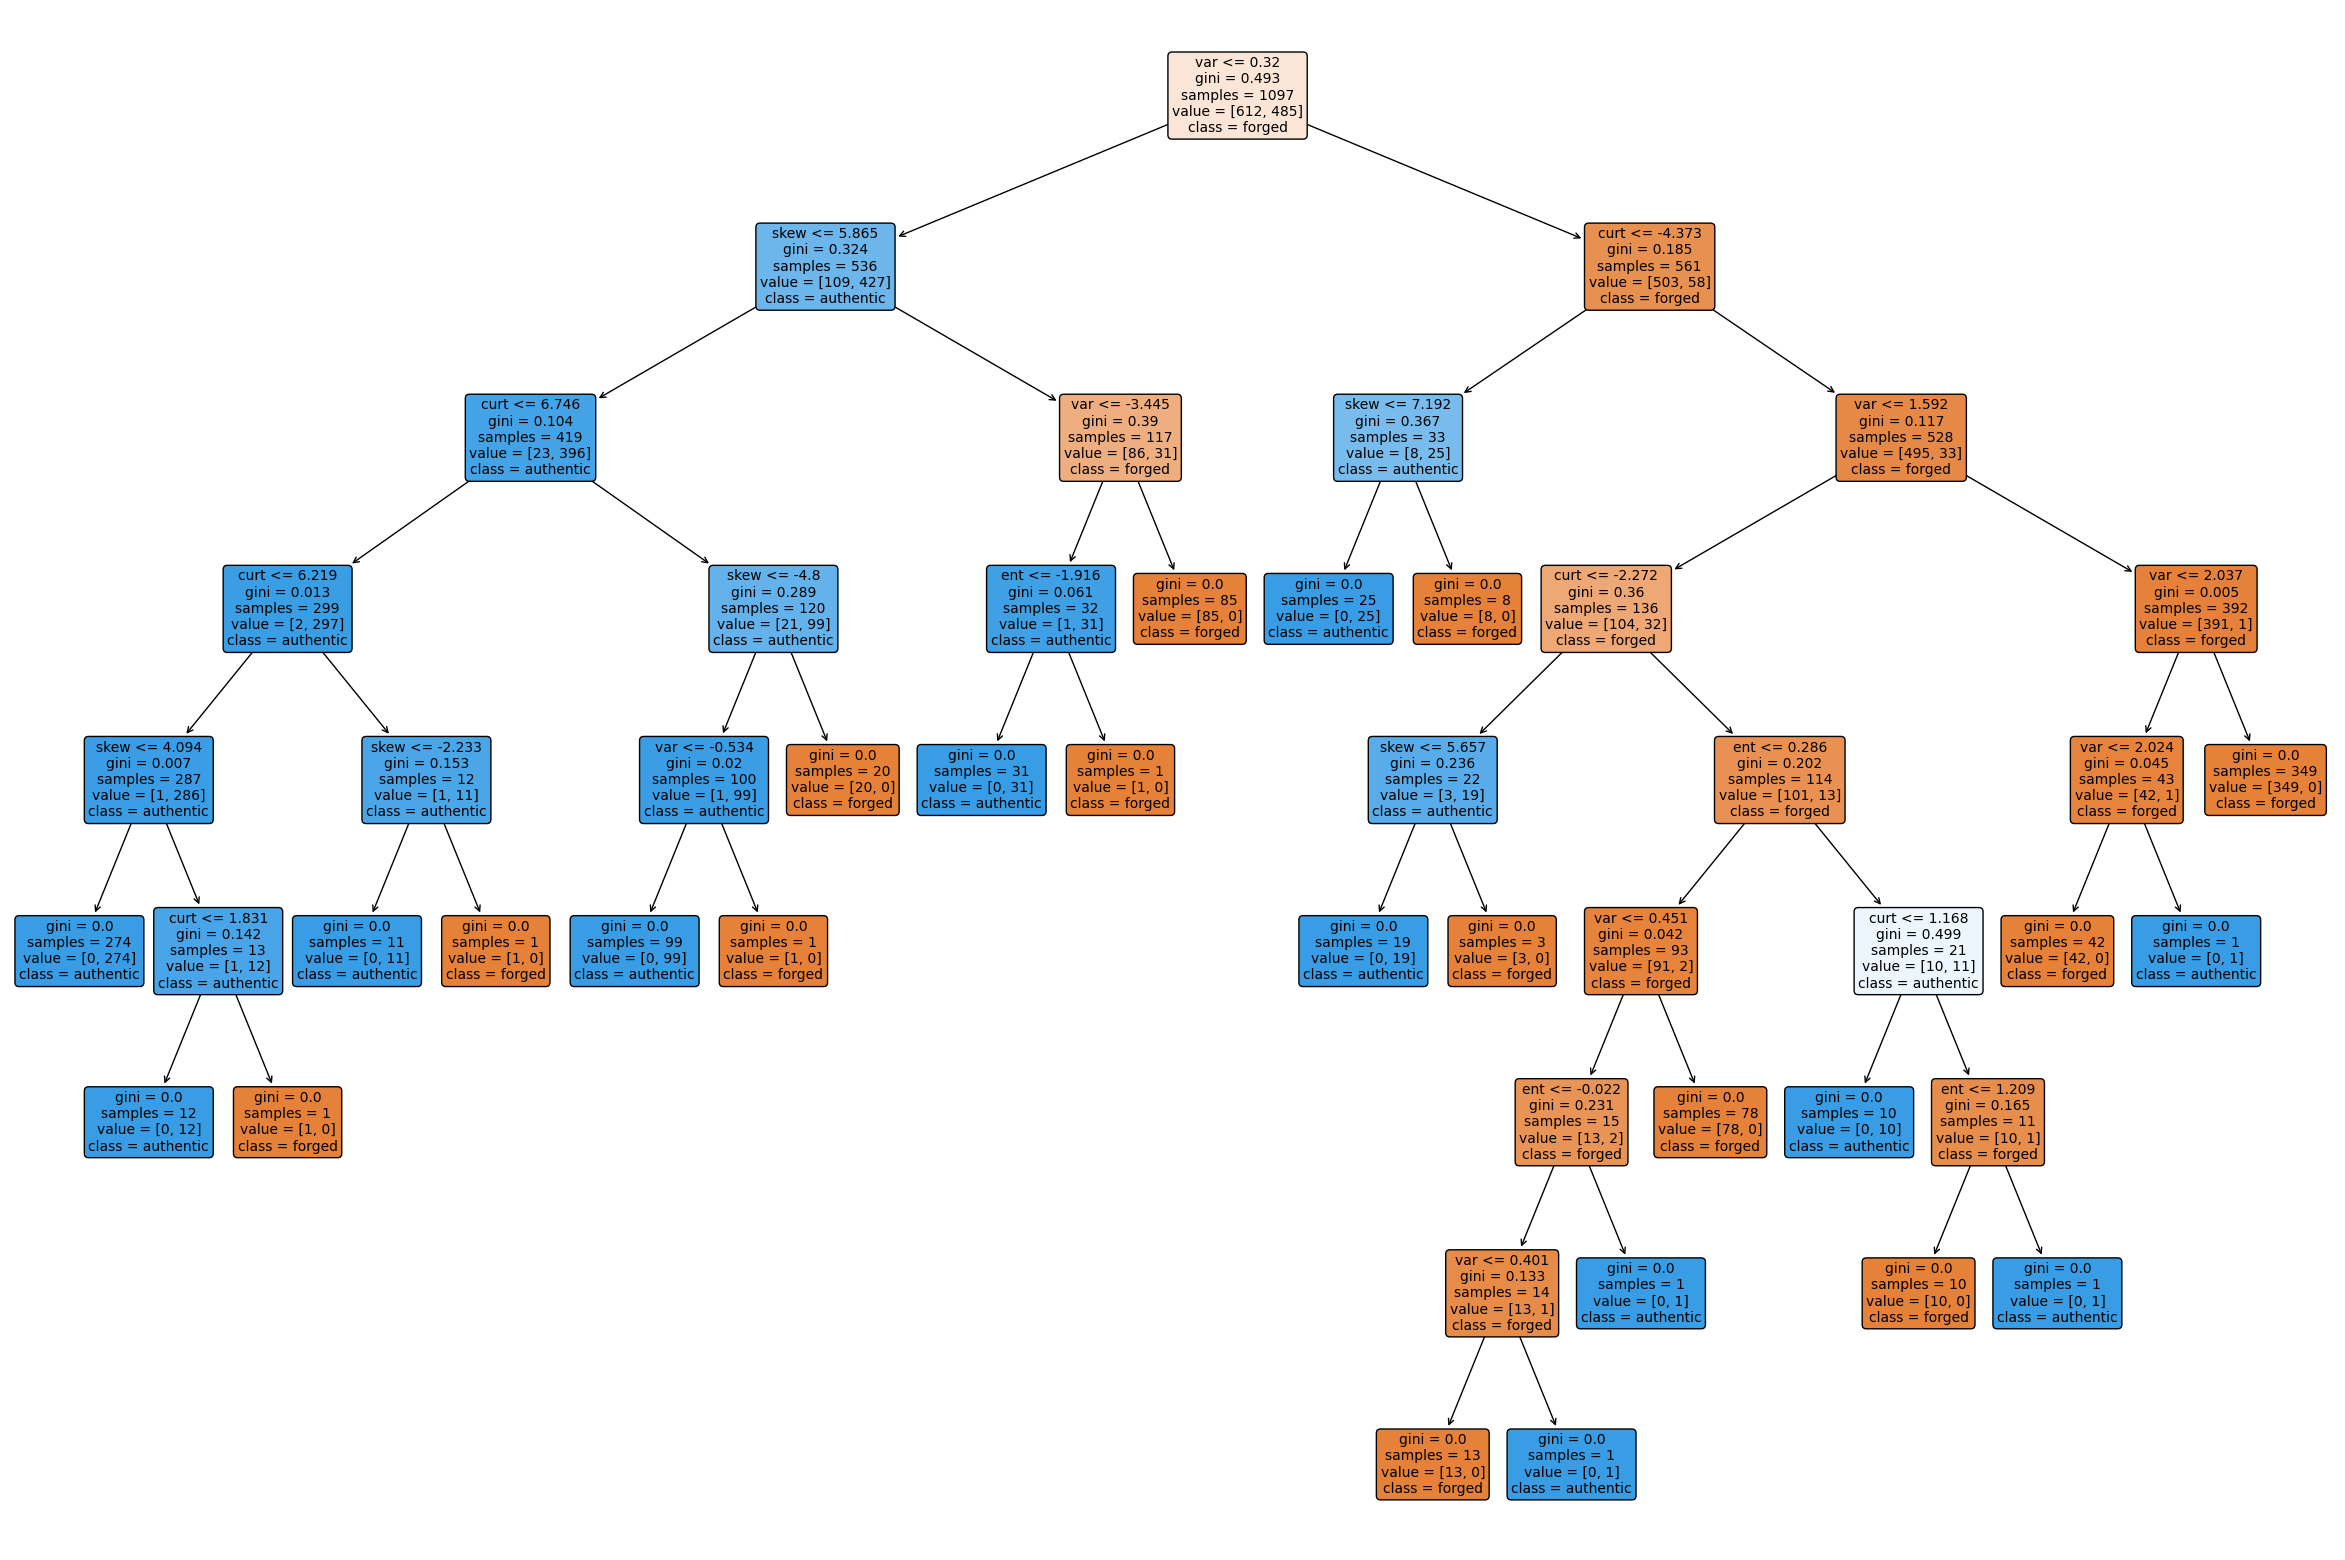

In [22]:
plotTree(clf)

##### searching for optimal perimeter using gridsearch cv which nothing but making crossproduct of all perimeter and try every possibility out there


In [23]:
params = {'max_depth': list(range(2, 20,2)), 'min_samples_split': list(range(2, 20,2)),'criterion':['gini', 'entropy', 'log_loss']}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(x_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18]},
             verbose=1)

In [24]:
print(grid_search_cv.best_estimator_," \nbest score is:   ",grid_search_cv.best_score_)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)  
best score is:    0.9872395638396089


In [25]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42)
model.fit(x_train, y_train)
predicted = model.predict(x_test)
accuracy = accuracy_score(predicted, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9927272727272727


##### decision tree regressor

In [26]:
clf = DecisionTreeRegressor()
clf.fit(x_train, y_train)
predicted_regressor = clf.predict(x_test)
accuracy = accuracy_score(predicted_regressor, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9745454545454545


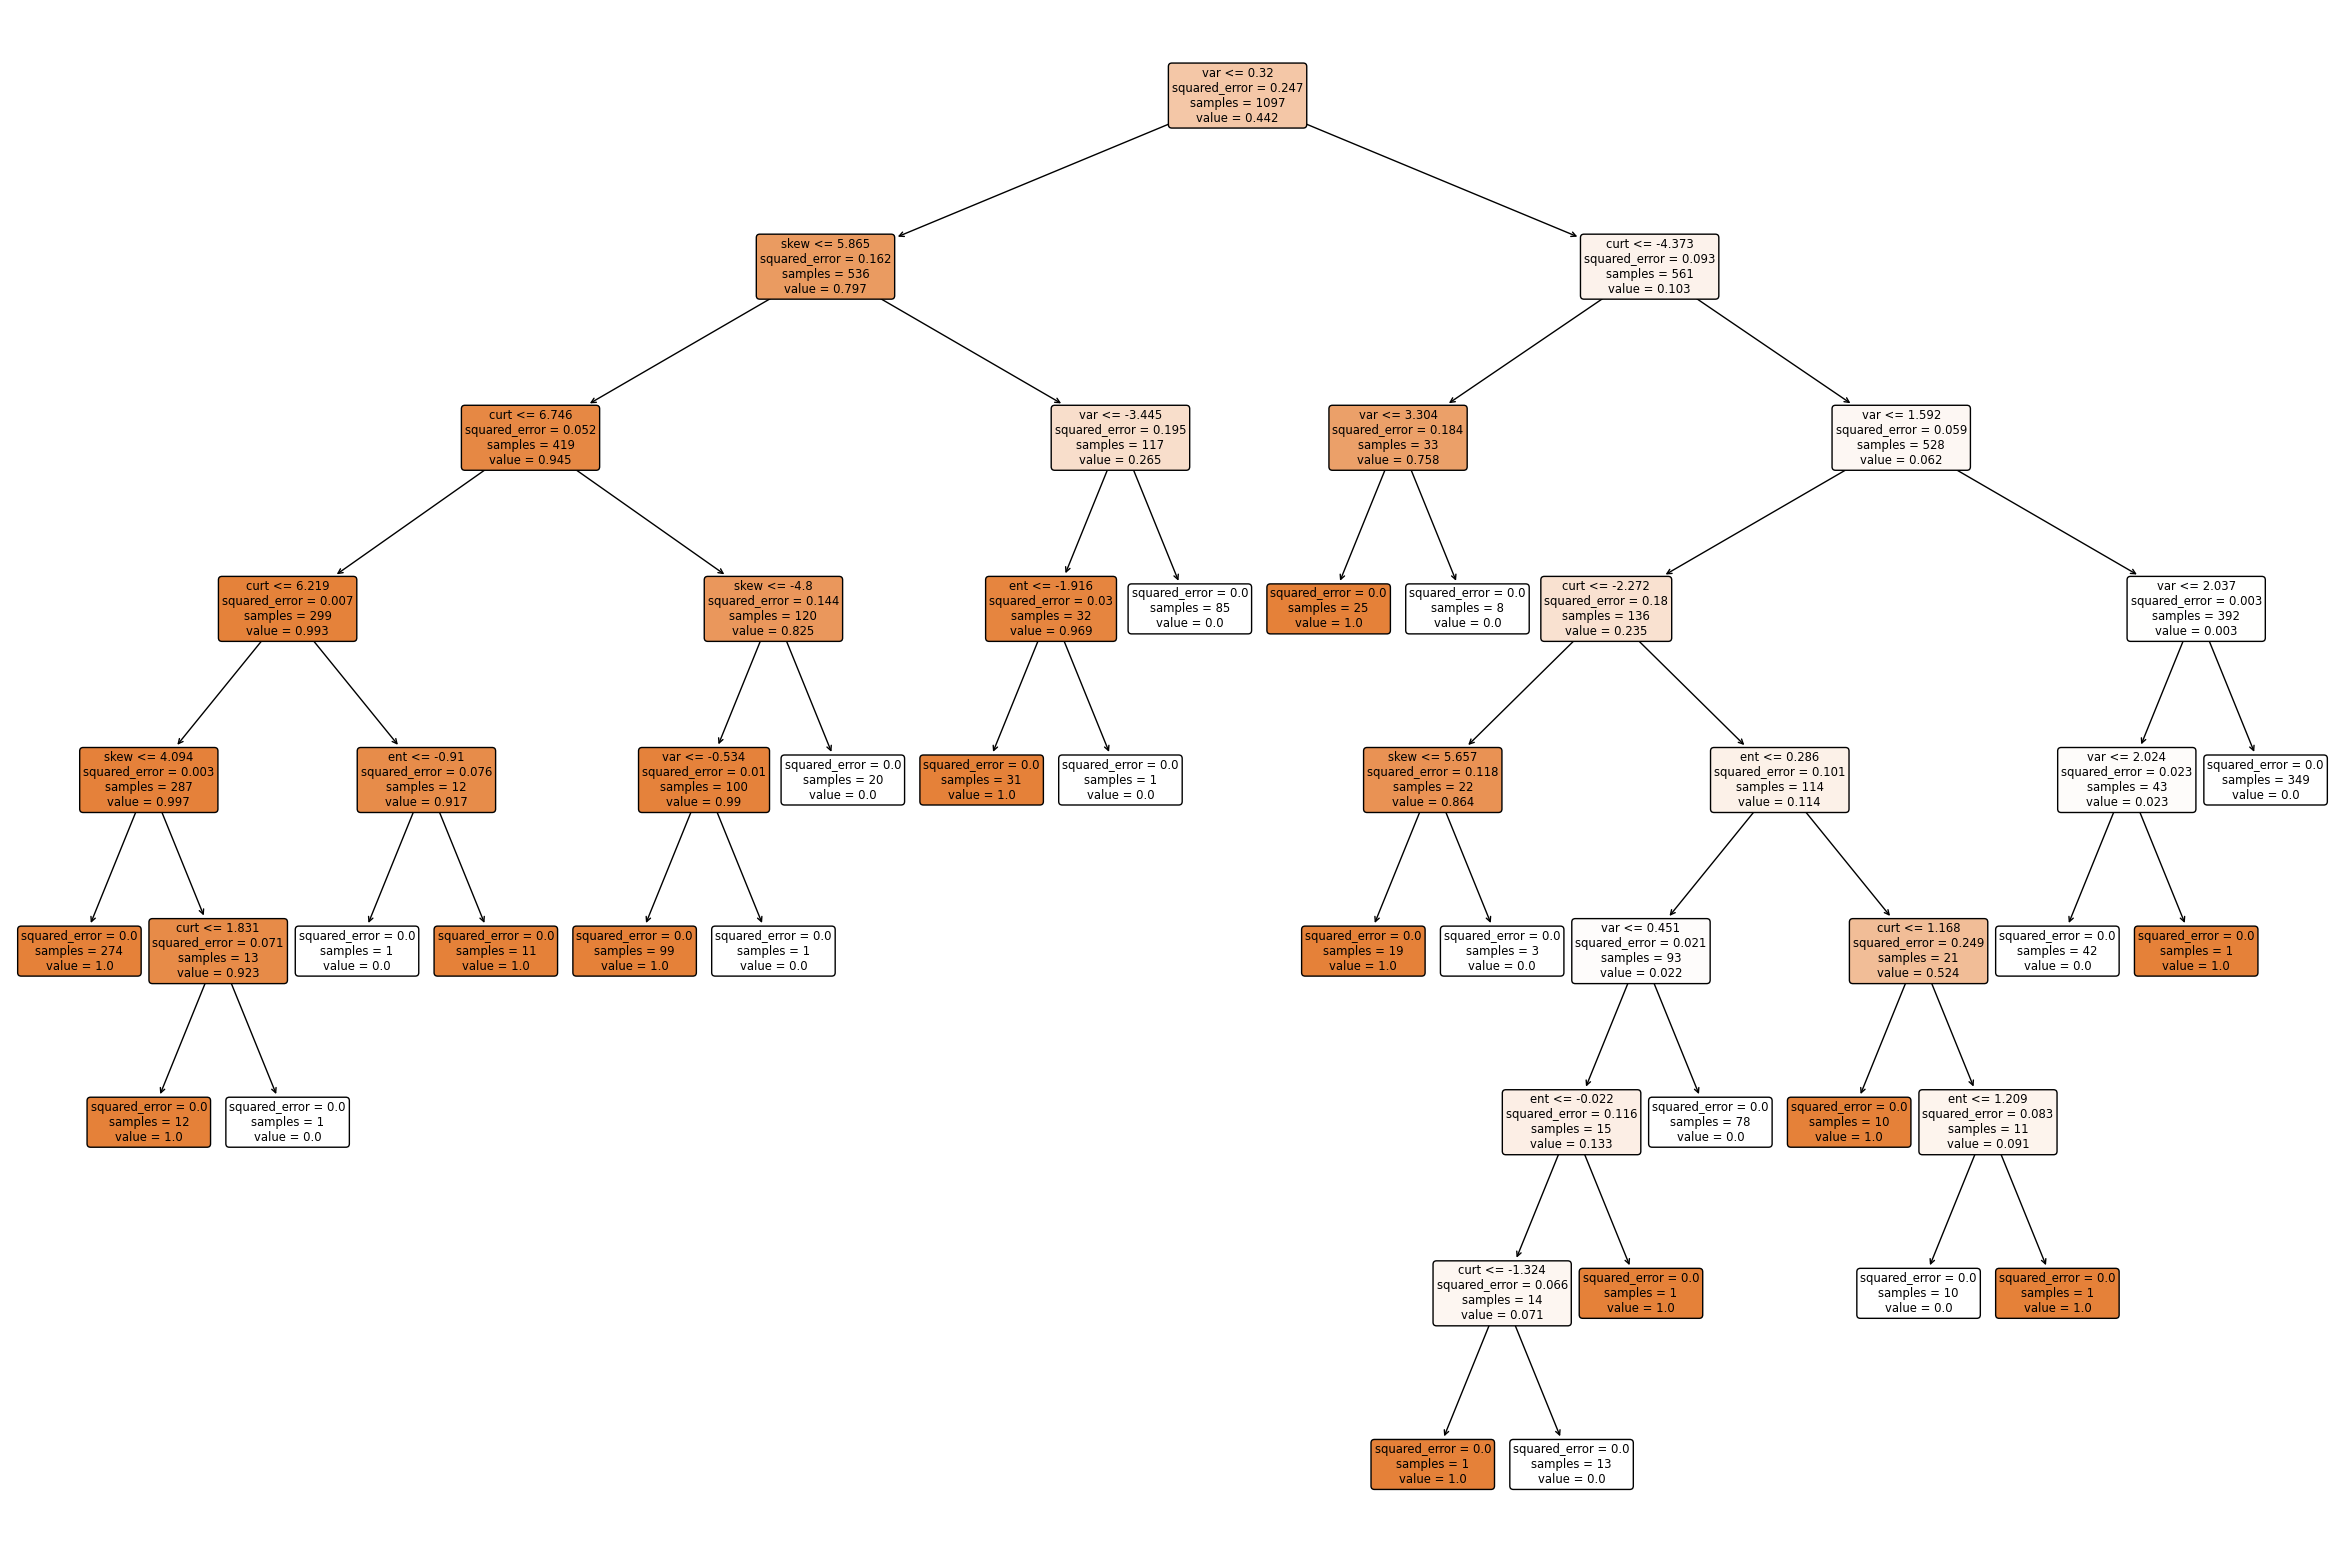

In [27]:
plotTree(clf)

##### Decision tree classifier vs decision tree regressor 
##### when to use which one?


The important difference btw decision tree classifier and decision tree regresor is index / error/criterion to use
when we have to predict real world value a squared error is good metric to decide the distance and error of actual value with predicted value so we should use the decision tree regressor as it predict the real value 

when we have classification problem where the output label is divided into classed it is advised to use the classifier as it predict the class of variable which it fall into

Thus for classification problem or where y/labels are discrete  -->> decision Tree classifier() 
where y/labels are continous and real valued-->> decision tree regressor()

#### what to use in this problem?

We know that bank note is either forged or not forged so we have only two categories here so using decision tree classifier is a better option in this problem

#### what to change in dataset to use decision tree regressor

As it the classification problem to use the decision tree regressor we have to roundoff out predicted value towards 0 and 1 thus the predicted values became discrete

### Denouement

Use this place to report all comparisons and wrap up the calls to the functions written above.

### Decision tree accuracies

#### Custom Decision tree  
#####       with max depth 3    ---------- 91.5 to ~95  (depend on split)
#####     with max depth 5    ---------- 94.4 to 97.6 (depend on split)
#####    with max depth 7    ---------- 96.1 to 1.0 (depend on split)


#### Sklearn Decision Tree classifier

##### with default perameter          96.5 to 98.6
##### with best hyperperameter by cv_search      98.5 to 99.6

#### Sklearn Decision Tree Regressor

##### with default perameter              96.4 to 99.4